# Import library, create environment and quick review on the numbers info

In [19]:
#import gym library
import gym
#Import numpy library for data processing
import numpy as np
#Other libraries for display/random/timing purpose
from IPython.display import clear_output
from time import sleep
import random
from IPython.display import clear_output
#Plotting library
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Implement the taxi environment
env = gym.make("Taxi-v3").env

env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [20]:
env.reset() # reset environment to a new, random state
env.render()

#Quick review on action spaces number and state space number of the environment
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


# Initialize environment, review state 328 for the solution later and render

In [21]:
#Initial the state with the same as instruction (taxi column 3, taxi row 1, passenger location index 0, destination index 2)
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

#Set the state = 328 follow the instruction to start with, then render out the visualization
env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



# Investigate the sample of reward table for state 328 for every it's next move (for solution use below)

In [22]:
#View the reward table for state 328 with corresponding move (0->6), each row has an order of 
#[(probability that making the move),(next state),(reward for the move),(is the training done yet ?)]
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [29]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    #Take a random action to perform from 6 defauld actions using action_space.sample()
    #then update the state, reward, done boolean and info variable
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    #Increase penalty for wrong pickup/dropoff action (Which has reward = -10)
    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1
    
##Output of average step and penalty of 100 solving time
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 39
Penalties incurred: 13


In [30]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 39
State: 85
Action: 5
Reward: 20


# Non-reinforcement method to solve the car park problem (random policy)

In [31]:
#Create a 100 times loop of 100 episodes of solving to calculate average total step was made and average penalties 
#to solve the taxi problem

loop_total =[]       #array to store loop number to solve the problem for each iteration of episode
pen_total = []       #array to store penalty time after the problem for each iteration of episode
rand_episode_reward_list = [] #array to store reward
episode_reward = 0 #variable store reward

for i in range(0,100):
    #Initialize loop number (step make) to solve the problem for each time
    loop_numb = 0
    
    #Initialize penalty - reward variable = 0 and done boolean = False
    rw = 0
    pen = 0
    done = False

    #Set initialize state of the environment is 328
    state_numb = 328
    env.s = state_numb
    #While loop with end condition : the problem is solve (done == True) for 1 episode
    while (done != True):
        #Increase a loop counter
        loop_numb += 1

        #Take a random action to perform from 6 defauld actions using action_space.sample()
        #then update the state, reward, done boolean and info variable
        action = env.action_space.sample()
        state, rw, done, info = env.step(action)

        episode_reward = episode_reward + reward

        #Increase penalty for wrong pickup/dropoff action (Which has reward = -10)
        if rw == -10:
            pen += 1

        # Collect step frame for later rendering (use if need)
        #step_frame.append({'frame': env.render(mode='ansi') ,'state': state ,'action': action ,'reward': rw})
    
    #Update result of this solving to the array
    #print(i,loop_numb,pen)
    loop_total.append(loop_numb)
    pen_total.append(pen)
    rand_episode_reward_list.append(episode_reward)
    episode_reward = 0

#Output of average step and penalty of 100 solving time
print("Average (100 episodes) steps make to solve the problem :",sum(loop_total)/100)
print("Average (100 episodes) penalties (number of incorrect pickup/dropoff):",sum(pen_total)/100)

Average (100 episodes) steps make to solve the problem : 859.68
Average (100 episodes) penalties (number of incorrect pickup/dropoff): 277.24


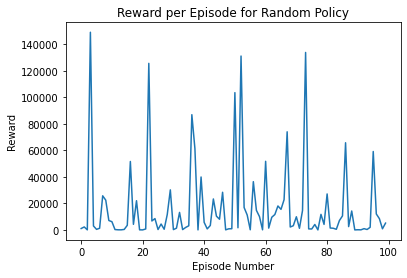

In [32]:
#plot the reward for each episode - random policy
plt.plot(rand_episode_reward_list)
plt.ylabel('Reward')
plt.xlabel('Episode Number')
plt.title("Reward per Episode for Random Policy")
plt.show()

# Reinforcement method to solve taxi problem - Q-learning method

1. TRAINING THE Q-TABLE FOR THE OPTIMIZATION TO TAKE THE ACTION FOR EVERY STATES

In [33]:
#Create a table of 0 (which number of row is the state space number (500) 
#and number of column is action number (6))
space_numb = env.observation_space.n    #500
action_numb = env.action_space.n        #6
Qtable = np.zeros([space_numb,action_numb])
print(Qtable)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [34]:
#Training step

#array store solvespeed for each training episode for visualization of training process
solvespeed_array =[] 

#Initialize 3 hyperparameter alpha, gamma and epsilon following the standard values from instruction
alpha = 0.1
gamma = 0.6
epsilon = 0.1

#For loop training, update the Q-table through decent episode number (100000 follow the instruction)
for index in range(1,100001):
    #Set initialize state of the environment to be random
    state = env.reset()
    
    #Initialize loop number (step make) to solve the problem for each time
    loop_numb = 0
    
    #Initialize penalty - reward variable = 0 and done boolean = False
    rw = 0
    pen = 0
    done = False
    
    #Solve speed variable to store solve speed of every training episode
    solvespeed = 0
    #While loop with end condition : the problem is solve (done == True) for 1 episode
    while (done != True):
        #Increase a loop counter
        loop_numb += 1
        
        #Draw a random action to exloit the computed Q-value
        #then update the next state it'll take, reward, done boolean and info variable
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(Qtable[state]) # Exploit learned values
        next_state, rw, done, info = env.step(action) 
        
        #Update new Qvalue for an action in the state space using the given formula
        #Q(state,action) ← (1−α)Q(state,action) + α(reward+γmax(a)Q(next state,all actions))
        
        #Qvalue for the state space and taken action
        old_value = Qtable[state, action]  
        
        #next max qvalue for the state space
        next_max = np.max(Qtable[next_state])    
        
        #update the new Qvalue for the cell in table
        new_value = (1 - alpha) * old_value + alpha * (rw + gamma * next_max)    
        Qtable[state, action] = new_value
        
        #Update the solvespeed by 1
        solvespeed+=1
        #Increase penalty for wrong pickup/dropoff action (Which has reward = -10)
        if rw == -10:
            pen += 1
        #Declare the next state after taking the action from current state
        state = next_state
    solvespeed_array.append(solvespeed)
print(Qtable)
print("Done.\n")

[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.41837066  -2.3639511   -2.41837066  -2.3639511   -2.27325184
  -11.36395003]
 [ -1.870144    -1.45024001  -1.870144    -1.45024     -0.7504
  -10.4502396 ]
 ...
 [ -1.10534566   0.41599995  -1.06802319  -1.18106719  -5.15539399
   -4.64285604]
 [ -2.14631887  -2.12205447  -2.14378952  -2.12205596  -6.17698632
   -5.03112719]
 [  2.51976796   1.25972579   2.51429259  11.          -1.982824
   -2.47020081]]
Done.



2. Method effectiveness evaluation by apply trained model to solve taxi problem from random state space

In [35]:
loop_total =[]       #array to store loop number to solve the problem for each iteration of episode
pen_total = []       #array to store penalty time after the problem for each iteration of episode

for i in range(0,100):
    #Initialize loop number (step make) to solve the problem for each time
    loop_numb = 0
    
    #Initialize penalty - reward variable = 0 and done boolean = False
    rw = 0
    pen = 0
    done = False
    
    #Create a random state space
    state = env.reset()
    
    while (done != True):
        
        #Take an action with maximum Q-value to perform using np.argmax(Qtable[state])
        #then update the state, reward, done boolean and info variable
        action = np.argmax(Qtable[state])
        state, rw, done, info = env.step(action)
        
        #Increase penalty for wrong pickup/dropoff action (Which has reward = -10)
        if rw == -10:
            pen += 1

        loop_numb += 1

    #Update result of this solving to the array
    #print(i,loop_numb,pen)
    loop_total.append(loop_numb)
    pen_total.append(pen)
    
#Output of average step and penalty of 100 solving time
print(f"Results after 100 episodes:")
print(f"Average timesteps per episode: ", sum(loop_total)/100)
print(f"Average penalties per episode: ",sum(pen_total)/100)
    

Results after 100 episodes:
Average timesteps per episode:  13.32
Average penalties per episode:  0.0


3. Learning speed visualization

Text(0, 0.5, 'Total step make for solution')

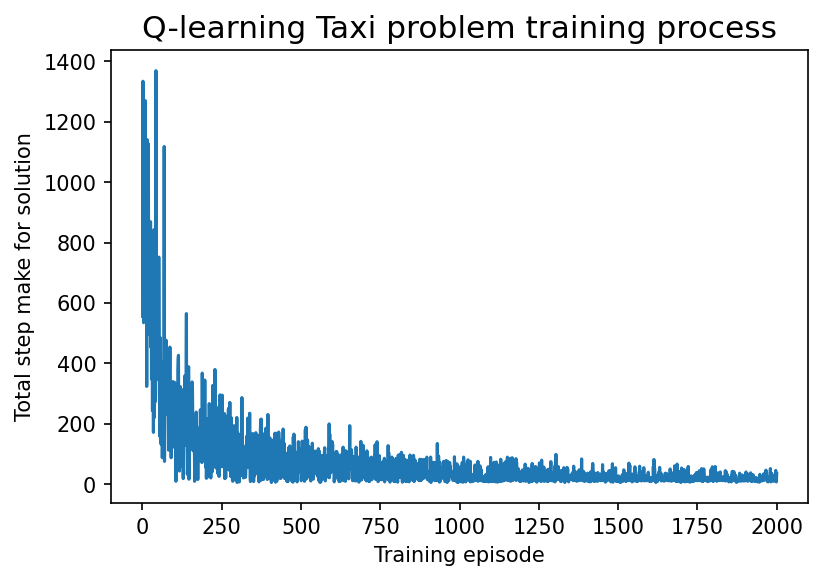

In [36]:
#Create variable x to store training episodes order for the first 2000 episodes (in 100000 episodes total) in our training
x = []
for i in range (1,2001):
    x.append(i)
    
#y is the number of step for successful solve Taxi problem for each episode in our first 2000 episode of training (recorded above)
y = solvespeed_array[0:2000]

#Graph
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.plot(x, y)

#Name the elements
ax.set_title('Q-learning Taxi problem training process', fontsize=15)
ax.set_xlabel('Training episode', fontsize=10)
ax.set_ylabel('Total step make for solution', fontsize=10)